In [1]:
"""
Epipolar Constraints for Self-Supervised Keypoint Detection

@author: Ganesh Sistu
"""
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# Use any pair of images captured from the same camera with an unknown
# transformation matrix R/t (will be calculated as part of the essential matrix)

# K = np.array([[391.469, 0, 192],
#               [0, 342.976, 112],
#               [0, 0, 1]])

# img1 = cv2.imread('DSCF4668.JPG')
# img2 = cv2.imread('DSCF4669.JPG')
# # Resize images
# dim = (384, 224)
# image1 = cv2.resize(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), dim)
# image2 = cv2.resize(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), dim)

In [2]:
# Camera calibration and distortion parameters (OpenCV) kitti-odometry-grayscale dataset
# Camera.fx: 707.0912
# Camera.fy: 707.0912
# Camera.cx: 601.8873
# Camera.cy: 183.1104

# Camera.k1: 0.0
# Camera.k2: 0.0
# Camera.p1: 0.0
# Camera.p2: 0.0

K = np.array([[707.0912, 0, 601.8873],
              [0, 707.0912, 183.1104],
              [0, 0, 1]])

In [3]:
import glob
image_0_path_list = glob.glob('/spslam/kitti-odometry-gray/sequences/07/image_0/*')
image_0_path_list.sort()
print(image_0_path_list[1001])
# image_1_path_list = glob.glob('/spslam/kitti-odometry-gray/sequences/07/image_1/*')
# print(image_1_path_list[1001])


/spslam/kitti-odometry-gray/sequences/07/image_0/001001.png


In [4]:
img1 = cv2.imread(image_0_path_list[1], cv2.IMREAD_UNCHANGED)
img2 = cv2.imread(image_0_path_list[2], cv2.IMREAD_UNCHANGED)

img1_list = []
# img2_list = []

# Resize images
dim = (384, 224)
image1 = cv2.resize(img1, dim)
image2 = cv2.resize(img2, dim)

for i in range(len(image_0_path_list)):
    img1_list.append(cv2.imread(image_0_path_list[i], cv2.IMREAD_UNCHANGED))
#     img2_list.append(cv2.imread(image_1_path_list[i], cv2.IMREAD_UNCHANGED))

In [6]:
def find_essential_matrix(img1, img2, K):
    # Convert images to grayscale
#     gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    gray1 = img1
    gray2 = img2
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # FLANN parameters and matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
# #     Draw the good matches
#     img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good, None, flags=2)
#     plt.imshow(img_matches)
#     plt.axis('off')  # Turn off axis numbers
#     plt.show()
    # Minimum number of matches
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Compute the Essential Matrix
        E, mask = cv2.findEssentialMat(src_pts, dst_pts, K)
        return E
    else:
        print(f"Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")
        return None

# find the essential matrix
essential_matrix = find_essential_matrix(image1, image2, K)
print("Essential Matrix:\n", essential_matrix)


Essential Matrix:
 [[-3.57930438e-04 -6.08936987e-01 -6.36795165e-02]
 [ 6.08408094e-01 -6.82647425e-04  3.54729126e-01]
 [ 6.30288434e-02 -3.53799743e-01 -1.21287062e-04]]


In [7]:
from superpoint import SuperPoint
config = {
        'superpoint': {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': -1
        }
}

In [8]:
import torch
import torch.nn.functional as F
from torchvision import models

# class KpPostProcess(torch.nn.Module):

#     def __init__(self, grid_size, scale_factor):
#         super(KpPostProcess, self).__init__()
#         self.scale_factor = scale_factor
#         self.grid_size = grid_size

#     def forward(self, features):
#         batch_size, channels, height, width = features.size()
#         # Generate grid indices
#         h_indices = torch.arange(0, height, grid_size)
#         w_indices = torch.arange(0, width, grid_size)
#         h_grid, w_grid = torch.meshgrid(h_indices, w_indices, indexing='ij')
#         grid_indices = torch.stack([h_grid, w_grid], dim=-1).reshape(-1, 2)  # Shape: [num_grids, 2]
#         # Initialize keypoints and descriptors
#         num_grids = grid_indices.shape[0]
#         keypoints = torch.zeros((batch_size, num_grids, 2)).float()
#         keypoints_probs = torch.zeros((batch_size, num_grids, 1)).float()

#         descriptors = torch.zeros((batch_size, num_grids, channels))

#         # Reshape features for batch processing
#         features_reshaped = features.view(batch_size, channels, -1)  # Shape: [batch_size, channels, H*W]

#         # Process each grid cell
#         for i, (h, w) in enumerate(grid_indices):
#             grid = features[:, :, h:h+grid_size, w:w+grid_size]
#             grid_flat = grid.reshape(batch_size, channels, -1)  # Flatten the grid
#             grid_mean = grid_flat.mean(dim=1)  # does this mean taking average of features?

#             # Compute keypoint probabilities and get max indices
#             keypoint_probs = F.softmax(grid_mean, dim=1)
#             max_idxs = keypoint_probs.argmax(dim=1,keepdim=True)
#             # Calculate (x, y) coordinates of keypoints
#             y_coords = (h + max_idxs // grid_size).float() * scale_factor
#             x_coords = (w + max_idxs % grid_size).float() * scale_factor
#             keypoints[:, i, :] = torch.stack([y_coords, x_coords], dim=1)[:,:,0]
#             keypoints_probs[:, i, :] = keypoint_probs.max(dim=1,keepdim=True).values
#             # Extract descriptors
#             row = max_idxs // grid_size
#             col = max_idxs % grid_size
#             descriptors[:,i, :] = grid[:, :, row, col][:, :, 0, 0]

#         return keypoints, descriptors, keypoints_probs

class KpFeatures(torch.nn.Module):

    def __init__(self):#, grid_size, scale_factor):
        super(KpFeatures, self).__init__()
#         # Instantiate ResNet-18 without the final fully connected layer
#         resnet18 = models.resnet18(pretrained=True)
#         self.resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-2])
#         self.deconv1 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
#         self.deconv2 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
#         self.batch_norm = torch.nn.BatchNorm2d(256)
        self.model = SuperPoint(config)
#         self.post_process = KpPostProcess(grid_size, scale_factor)
    def forward(self, x):
#         # feature extractor
#         x = self.resnet18(x)
#         x = self.deconv1(x)
#         x = self.batch_norm(x)
#         x = self.deconv2(x)
#         # keypoint extraction
#         keypoints, descriptors, keypoints_probs = self.post_process(x)
        x = self.model(x)
#         keypoints, descriptors, keypoints_probs = self.post_process(x['descriptors'])
#         return keypoints, descriptors, keypoints_probs
        return torch.stack(x['keypoints']), torch.transpose(torch.stack(
            x['descriptors']), 1, 2), torch.stack(x['scores']).unsqueeze(dim = 2)


def normalize_keypoints(points, K_inv):
    """
    Normalize keypoints using the inverse camera intrinsic matrix.
    Assumes points are in the shape [batch_size, num_points, 2]
    K_inv is assumed to be [3, 3]
    """
    batch_size, num_points, _ = points.shape

    # Convert to homogeneous coordinates [batch_size, num_points, 3]
    ones = torch.ones(batch_size, num_points, 1, device=points.device)
    homogeneous_points = torch.cat([points, ones], dim=2)

    # Apply K_inv to each point
    # Reshape K_inv to broadcast across the batch
    K_inv_batch = K_inv.unsqueeze(0).repeat(batch_size, 1, 1)

    # Batch matrix multiplication
    normalized_points = torch.bmm(homogeneous_points, K_inv_batch.transpose(1, 2))

    return normalized_points


def sinkhorn_iterations(scores, max_iterations=20, epsilon=1e-3):
    # Apply Sinkhorn iterations for each element in the batch
    for _ in range(max_iterations):
        # Row normalization - ensure normalization is done for each batch separately
        scores = torch.nn.functional.softmax(scores, dim=2)

        # Column normalization - again, separate for each batch
        scores = torch.nn.functional.softmax(scores, dim=1)
    return scores

def contrastive_loss(desc1, desc2, soft_assignment, margin=1.0):
    batch_size, num_points, _ = desc1.shape

    # Calculate the pairwise distance matrix for each batch
    pairwise_distances = torch.cdist(desc1, desc2, p=2)  # Shape: [batch_size, num_points, num_points]

    # Positive pairs: Use soft_assignment as weights for the distances
    positive_loss = torch.sum(soft_assignment * pairwise_distances) / batch_size

    # Negative pairs: Push apart pairs with low assignment probability
    negative_loss = torch.sum((1 - soft_assignment) * torch.clamp(margin - pairwise_distances, min=0)) / batch_size

    loss = positive_loss + 0.5 * negative_loss
    loss = loss/num_points
    return loss


def sampson_distance(points1, points2, E):
    """
    Compute the Sampson distance for batched points and a single Essential Matrix.
    Assumes points1 and points2 are normalized and in homogeneous coordinates,
    with shape [batch_size, total_points, 3].
    E is the Essential Matrix with shape [3, 3].
    """
    # Ensure E is transposed correctly for batch matrix multiplication
    E_transposed = E.transpose(0, 1)  # Should be [3, 3]

    # Apply Essential Matrix to the points
    Fx1 = torch.bmm(points1, E_transposed.unsqueeze(0).repeat(points1.size(0), 1, 1))  # [batch_size, total_points, 3]
    Fx2 = torch.bmm(points2, E.unsqueeze(0).repeat(points2.size(0), 1, 1))             # [batch_size, total_points, 3]

    # Compute the error terms
    errors = (points2 * Fx1).sum(dim=2)  # [batch_size, total_points]

    # Compute the denominator
    denom = Fx1[:, :, 0]**2 + Fx1[:, :, 1]**2 + Fx2[:, :, 0]**2 + Fx2[:, :, 1]**2  # [batch_size, total_points]

    # Compute the Sampson distance
    sampson_dist = (errors**2 / denom).sum(dim=1)  # Sum over points, [batch_size]

    return sampson_dist  # Returns a tensor of shape [batch_size]

descriptor_loss_list = []
geometric_loss_list = []

def ep_loss(desc1, desc2, points1, points2, K, E, alpha, margin=1.0):
    # Descriptor similarity (Euclidean distance as an example)
    desc_distance = torch.cdist(desc1, desc2)
#     print('desc_distance', desc_distance.shape)
    desc_similarity = torch.nn.functional.softmax(-desc_distance, dim=2)
#     print('desc_similarity', desc_similarity.shape)
    soft_assignment = torch.softmax(desc_similarity, dim=1) 
    # size of soft assignment is changing in every epoch because it depends on number of descriptors
    print('soft_assignment', soft_assignment.shape)
    match_indices = torch.argmax(soft_assignment, dim=2)
    
	# Create a range tensor for batch indexing
    batch_indices = torch.arange(points2.size(0)).unsqueeze(1)
    # Use torch.gather to align points2 according to match_indices
    aligned_points2 = torch.gather(points2, 1, match_indices.unsqueeze(-1).expand(-1, -1, points2.size(-1)))
    # Normalize keypoints
    K_inv = torch.inverse(K)  # Inverse of camera intrinsic matrix
    normalized_points1 = normalize_keypoints(points1, K_inv)
    normalized_aligned_points2 = normalize_keypoints(aligned_points2, K_inv)
#     print(normalized_points1.shape, normalized_aligned_points2.shape)
    # Step 3: Calculate Sampson Distance for Geometric Loss
    geometric_loss = sampson_distance(normalized_points1, normalized_aligned_points2, E)

    # Descriptor loss (can be based on soft_assignment)
    descriptor_loss = contrastive_loss(desc1, desc2, soft_assignment, margin=1.0)

    # Combined loss
    descriptor_loss_list.append(descriptor_loss.item())
    geometric_loss_list.append(geometric_loss.item())
    combined_loss = alpha * descriptor_loss + (1 - alpha) * geometric_loss

    return combined_loss

# Function to move tensor to GPU if available
def move_to_gpu(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

# Function to convert a tensor to a numpy array
def tensor_to_numpy(tensor):
    # Move tensor to cpu first if it's on GPU
    if tensor.is_cuda:
        tensor = tensor.cpu()
    return tensor.numpy()


def filter_and_pad_points(prob_tensor, tensor1, tensor2, thresh=0.3, pad_value=0):
    """
    Filters the points in tensor1 and tensor2 across all batches at once based on the
    probability score threshold in prob_tensor, and pads the results to ensure equal size.
    """
#     print('prob_tensor:', prob_tensor.shape)
#     print('tensor1:', tensor1.shape)
#     print('tensor2:', tensor2.shape)
    batch_size, total_points, _ = prob_tensor.shape

    # Initialize lists to store filtered results
    filtered_tensor1_list = []
    filtered_tensor2_list = []

    # Filter each batch separately
    for b in range(batch_size):
        mask = prob_tensor[b, :, 0] > thresh
        filtered_tensor1_list.append(tensor1[b, mask].unsqueeze(0))  # Add a new dimension
        filtered_tensor2_list.append(tensor2[b, mask].unsqueeze(0))  # Add a new dimension

    # Concatenate the filtered results along a new dimension
    concatenated_tensor1 = torch.cat(filtered_tensor1_list, dim=0)
    concatenated_tensor2 = torch.cat(filtered_tensor2_list, dim=0)

    return concatenated_tensor1, concatenated_tensor2

In [9]:
# Define grid size and scale factor
grid_size = 3 # change based on the image encoder
scale_factor = 8 # depends on the image encoder

image1 = (image1.astype('float32') / 255.)
image2 = (image2.astype('float32') / 255.)

# pytorch data preparation
# opencv_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
# opencv_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
opencv_image11 = np.expand_dims(image1, axis = 0)
opencv_image22 = np.expand_dims(image2, axis = 0)
# # Rearrange the axes to [C, H, W]
# opencv_image1 = np.transpose(image1, (2, 0, 1))
# Convert to a float tensor
input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
# input1 = torch.unsqueeze(input1, dim = 0)

# # Rearrange the axes to [C, H, W]
# opencv_image2 = np.transpose(image2, (2, 0, 1))
# Convert to a float tensor
input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0)
# input2 = torch.unsqueeze(input2, dim = 0)

In [10]:
# kp_net = KpFeatures(grid_size, scale_factor)
kp_net = KpFeatures()
move_to_gpu(kp_net)
learning_rate = 1e-5
optimizer = torch.optim.RMSprop(kp_net.parameters(), lr=learning_rate)

Loaded SuperPoint model


torch.Size([1, 412, 2])
torch.Size([1, 409, 2])


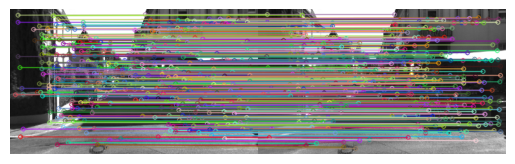

In [11]:
def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]


kp_net.eval()

with torch.no_grad():
    kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
    kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

    
# print(kp_1.shape)
# print(kp_2.shape)

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0)

print(kp_1.shape)
print(kp_2.shape)

infer_keypoints1 = kp_1.detach().cpu().numpy()
infer_keypoints2 = kp_2.detach().cpu().numpy()

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))
# print('matches:', matches[0])
# print('keypoints1:', keypoints1)
# print('keypoints2:', keypoints2)
# Apply Lowe's ratio
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
image1 = (image1*255.).astype('uint8')
image2 = (image2*255.).astype('uint8')
# Draw the top N matches
try:
    img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=2)
except:
    print("****************** ERROR DUE TO RANDOM MATCHES: TRY AFTER 10 EPOCHS ********************")

# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [13]:
kp_net.train()
for i in range(1):
    for j in range(len(img1_list)-1):
        image1 = img1_list[j]
        image2 = img1_list[j+1]
        img1 = cv2.resize(image1, dim)
        img2 = cv2.resize(image2, dim)
        
        K = np.array([[707.0912, 0, 601.8873],
              [0, 707.0912, 183.1104],
              [0, 0, 1]])        
        essential_matrix = find_essential_matrix(img1, img2, K)
        
        img1 = (img1.astype('float32') / 255.)
        img2 = (img2.astype('float32') / 255.)
        
        opencv_image11 = np.expand_dims(img1, axis = 0)
        opencv_image22 = np.expand_dims(img2, axis = 0)
        
        
        # Convert to a float tensor
        input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
        input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0)        
        
        keypoints1, des1, kp_prob1 = kp_net(move_to_gpu(input1))
        keypoints2, des2, kp_prob2 = kp_net(move_to_gpu(input2))
        
        
        E = torch.from_numpy(essential_matrix).float()
        K = torch.from_numpy(K).float()
        E = E.cuda()
        K = K.cuda()
        optimizer.zero_grad()
        combined_loss = ep_loss(des1, des2, keypoints1, keypoints2, K, E, alpha = 0.5, margin=1.0)
        if i % 1 == 0:
            print("epoch******", i, combined_loss.item())
        combined_loss.backward()
        optimizer.step()

soft_assignment torch.Size([1, 422, 412])
epoch****** 0 1.044510006904602
soft_assignment torch.Size([1, 424, 406])
epoch****** 0 0.9386193752288818
soft_assignment torch.Size([1, 462, 474])
epoch****** 0 0.9758586287498474
soft_assignment torch.Size([1, 521, 510])
epoch****** 0 0.9344134330749512
soft_assignment torch.Size([1, 537, 557])
epoch****** 0 0.9964854717254639
soft_assignment torch.Size([1, 545, 522])
epoch****** 0 0.9942620396614075
soft_assignment torch.Size([1, 541, 555])
epoch****** 0 0.9690070748329163
soft_assignment torch.Size([1, 502, 494])
epoch****** 0 0.9074784517288208
soft_assignment torch.Size([1, 507, 533])
epoch****** 0 0.9727849960327148
soft_assignment torch.Size([1, 509, 496])
epoch****** 0 0.8907886743545532
soft_assignment torch.Size([1, 531, 525])
epoch****** 0 0.8997732400894165
soft_assignment torch.Size([1, 503, 502])
epoch****** 0 0.9868841171264648
soft_assignment torch.Size([1, 518, 511])
epoch****** 0 0.9307321310043335
soft_assignment torch.Size

soft_assignment torch.Size([1, 432, 467])
epoch****** 0 1.0881297588348389
soft_assignment torch.Size([1, 444, 454])
epoch****** 0 1.08109450340271
soft_assignment torch.Size([1, 445, 421])
epoch****** 0 1.0351488590240479
soft_assignment torch.Size([1, 340, 366])
epoch****** 0 0.9622068405151367
soft_assignment torch.Size([1, 404, 453])
epoch****** 0 1.0715067386627197
soft_assignment torch.Size([1, 461, 373])
epoch****** 0 0.8652878403663635
soft_assignment torch.Size([1, 388, 399])
epoch****** 0 0.9028538465499878
soft_assignment torch.Size([1, 384, 367])
epoch****** 0 0.9009455442428589
soft_assignment torch.Size([1, 353, 401])
epoch****** 0 1.0247313976287842
soft_assignment torch.Size([1, 414, 426])
epoch****** 0 0.904605507850647
soft_assignment torch.Size([1, 392, 399])
epoch****** 0 0.9570286870002747
soft_assignment torch.Size([1, 409, 389])
epoch****** 0 0.9610114693641663
soft_assignment torch.Size([1, 376, 365])
epoch****** 0 0.9643851518630981
soft_assignment torch.Size([

soft_assignment torch.Size([1, 190, 205])
epoch****** 0 0.907661497592926
soft_assignment torch.Size([1, 189, 184])
epoch****** 0 0.8959060907363892
soft_assignment torch.Size([1, 201, 212])
epoch****** 0 0.9877582788467407
soft_assignment torch.Size([1, 178, 176])
epoch****** 0 0.8681098222732544
soft_assignment torch.Size([1, 184, 192])
epoch****** 0 0.9683569073677063
soft_assignment torch.Size([1, 161, 174])
epoch****** 0 0.9331159591674805
soft_assignment torch.Size([1, 173, 154])
epoch****** 0 0.7646974325180054
soft_assignment torch.Size([1, 169, 157])
epoch****** 0 0.8161910772323608
soft_assignment torch.Size([1, 156, 204])
epoch****** 0 1.057316780090332
soft_assignment torch.Size([1, 181, 149])
epoch****** 0 0.7627917528152466
soft_assignment torch.Size([1, 139, 168])
epoch****** 0 0.9298733472824097
soft_assignment torch.Size([1, 161, 157])
epoch****** 0 0.7946114540100098
soft_assignment torch.Size([1, 190, 196])
epoch****** 0 0.850681722164154
soft_assignment torch.Size([

soft_assignment torch.Size([1, 151, 141])
epoch****** 0 0.7696411609649658
soft_assignment torch.Size([1, 135, 146])
epoch****** 0 0.813785970211029
soft_assignment torch.Size([1, 154, 155])
epoch****** 0 0.8390956521034241
soft_assignment torch.Size([1, 156, 164])
epoch****** 0 0.8191136717796326
soft_assignment torch.Size([1, 171, 163])
epoch****** 0 0.7773645520210266
soft_assignment torch.Size([1, 164, 209])
epoch****** 0 0.9400829076766968
soft_assignment torch.Size([1, 212, 185])
epoch****** 0 0.7832293510437012
soft_assignment torch.Size([1, 207, 194])
epoch****** 0 0.8023397922515869
soft_assignment torch.Size([1, 235, 274])
epoch****** 0 0.9403712749481201
soft_assignment torch.Size([1, 224, 203])
epoch****** 0 0.7454790472984314
soft_assignment torch.Size([1, 208, 198])
epoch****** 0 0.8274767398834229
soft_assignment torch.Size([1, 198, 185])
epoch****** 0 0.7978687286376953
soft_assignment torch.Size([1, 156, 126])
epoch****** 0 0.6524894833564758
soft_assignment torch.Size

soft_assignment torch.Size([1, 144, 123])
epoch****** 0 0.7266646027565002
soft_assignment torch.Size([1, 134, 176])
epoch****** 0 0.9958340525627136
soft_assignment torch.Size([1, 193, 171])
epoch****** 0 0.7692655324935913
soft_assignment torch.Size([1, 181, 180])
epoch****** 0 0.806358814239502
soft_assignment torch.Size([1, 178, 163])
epoch****** 0 0.8171776533126831
soft_assignment torch.Size([1, 164, 181])
epoch****** 0 0.8648690581321716
soft_assignment torch.Size([1, 167, 138])
epoch****** 0 0.790327787399292
soft_assignment torch.Size([1, 146, 164])
epoch****** 0 1.0412609577178955
soft_assignment torch.Size([1, 192, 176])
epoch****** 0 0.9417352676391602
soft_assignment torch.Size([1, 140, 129])
epoch****** 0 0.7494279742240906
soft_assignment torch.Size([1, 123, 125])
epoch****** 0 0.8627287149429321
soft_assignment torch.Size([1, 118, 120])
epoch****** 0 0.8489922881126404
soft_assignment torch.Size([1, 121, 111])
epoch****** 0 0.8932695388793945
soft_assignment torch.Size(

soft_assignment torch.Size([1, 213, 172])
epoch****** 0 0.7395042181015015
soft_assignment torch.Size([1, 163, 182])
epoch****** 0 0.9184549450874329
soft_assignment torch.Size([1, 199, 222])
epoch****** 0 0.9441646337509155
soft_assignment torch.Size([1, 215, 196])
epoch****** 0 0.9233025312423706
soft_assignment torch.Size([1, 200, 202])
epoch****** 0 0.9754937887191772
soft_assignment torch.Size([1, 186, 190])
epoch****** 0 0.9596028327941895
soft_assignment torch.Size([1, 181, 186])
epoch****** 0 0.8518997430801392
soft_assignment torch.Size([1, 164, 169])
epoch****** 0 0.8498616218566895
soft_assignment torch.Size([1, 162, 183])
epoch****** 0 0.9170187711715698
soft_assignment torch.Size([1, 166, 157])
epoch****** 0 0.8216016292572021
soft_assignment torch.Size([1, 154, 137])
epoch****** 0 0.8149528503417969
soft_assignment torch.Size([1, 137, 193])
epoch****** 0 1.161534309387207
soft_assignment torch.Size([1, 177, 134])
epoch****** 0 0.7532936334609985
soft_assignment torch.Size

soft_assignment torch.Size([1, 70, 56])
epoch****** 0 0.6348233222961426
soft_assignment torch.Size([1, 61, 88])
epoch****** 0 1.046322226524353
soft_assignment torch.Size([1, 93, 94])
epoch****** 0 0.8219990134239197
soft_assignment torch.Size([1, 88, 90])
epoch****** 0 0.8858551383018494
soft_assignment torch.Size([1, 92, 93])
epoch****** 0 0.8760438561439514
soft_assignment torch.Size([1, 96, 114])
epoch****** 0 0.8984272480010986
soft_assignment torch.Size([1, 80, 87])
epoch****** 0 0.8048062920570374
soft_assignment torch.Size([1, 78, 68])
epoch****** 0 0.6677269339561462
soft_assignment torch.Size([1, 80, 70])
epoch****** 0 0.6744289994239807
soft_assignment torch.Size([1, 73, 69])
epoch****** 0 0.7479902505874634
soft_assignment torch.Size([1, 59, 53])
epoch****** 0 0.8947001099586487
soft_assignment torch.Size([1, 60, 71])
epoch****** 0 0.8783463835716248
soft_assignment torch.Size([1, 69, 56])
epoch****** 0 0.6312554478645325
soft_assignment torch.Size([1, 47, 50])
epoch******

soft_assignment torch.Size([1, 59, 70])
epoch****** 0 0.7960249185562134
soft_assignment torch.Size([1, 62, 29])
epoch****** 0 0.3706538677215576
soft_assignment torch.Size([1, 30, 49])
epoch****** 0 1.04246187210083
soft_assignment torch.Size([1, 35, 38])
epoch****** 0 0.7145609855651855
soft_assignment torch.Size([1, 47, 48])
epoch****** 0 0.7327008247375488
soft_assignment torch.Size([1, 47, 37])
epoch****** 0 0.5350927114486694
soft_assignment torch.Size([1, 40, 39])
epoch****** 0 0.6280620694160461
soft_assignment torch.Size([1, 38, 58])
epoch****** 0 0.9559445381164551
soft_assignment torch.Size([1, 52, 56])
epoch****** 0 0.7217580676078796
soft_assignment torch.Size([1, 60, 50])
epoch****** 0 0.58491051197052
soft_assignment torch.Size([1, 54, 49])
epoch****** 0 0.6647520065307617
soft_assignment torch.Size([1, 62, 84])
epoch****** 0 0.93464195728302
soft_assignment torch.Size([1, 60, 36])
epoch****** 0 0.4577433466911316
soft_assignment torch.Size([1, 30, 56])
epoch****** 0 1.1

soft_assignment torch.Size([1, 44, 43])
epoch****** 0 0.6556048393249512
soft_assignment torch.Size([1, 39, 35])
epoch****** 0 0.6116189956665039
soft_assignment torch.Size([1, 38, 46])
epoch****** 0 0.7887605428695679
soft_assignment torch.Size([1, 46, 48])
epoch****** 0 0.6967037916183472
soft_assignment torch.Size([1, 53, 50])
epoch****** 0 0.6382728815078735
soft_assignment torch.Size([1, 66, 48])
epoch****** 0 0.5078297257423401
soft_assignment torch.Size([1, 45, 41])
epoch****** 0 0.6090680360794067
soft_assignment torch.Size([1, 42, 44])
epoch****** 0 0.6745074391365051
soft_assignment torch.Size([1, 46, 55])
epoch****** 0 0.7655808329582214
soft_assignment torch.Size([1, 58, 68])
epoch****** 0 0.7749233841896057
soft_assignment torch.Size([1, 61, 46])
epoch****** 0 0.5308350324630737
soft_assignment torch.Size([1, 46, 43])
epoch****** 0 0.6264114379882812
soft_assignment torch.Size([1, 43, 44])
epoch****** 0 0.6804619431495667
soft_assignment torch.Size([1, 43, 49])
epoch******

soft_assignment torch.Size([1, 63, 60])
epoch****** 0 0.6655603647232056
soft_assignment torch.Size([1, 57, 65])
epoch****** 0 0.7941046953201294
soft_assignment torch.Size([1, 61, 47])
epoch****** 0 0.5459613800048828
soft_assignment torch.Size([1, 48, 57])
epoch****** 0 0.791249692440033
soft_assignment torch.Size([1, 64, 48])
epoch****** 0 0.5695292353630066
soft_assignment torch.Size([1, 53, 75])
epoch****** 0 0.9364522099494934
soft_assignment torch.Size([1, 73, 67])
epoch****** 0 0.6718745231628418
soft_assignment torch.Size([1, 69, 52])
epoch****** 0 0.5829359292984009
soft_assignment torch.Size([1, 58, 37])
epoch****** 0 0.4618576467037201
soft_assignment torch.Size([1, 38, 67])
epoch****** 0 1.1111054420471191
soft_assignment torch.Size([1, 60, 86])
epoch****** 0 0.9810135364532471
soft_assignment torch.Size([1, 64, 56])
epoch****** 0 0.598578929901123
soft_assignment torch.Size([1, 63, 31])
epoch****** 0 0.38236019015312195
soft_assignment torch.Size([1, 31, 43])
epoch****** 

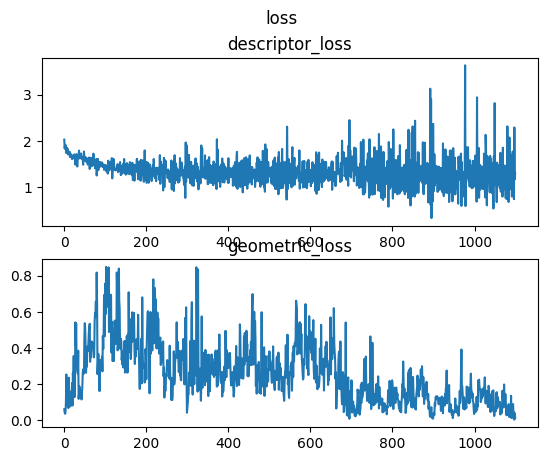

In [14]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('loss')
ax1.set_title('descriptor_loss')
ax2.set_title('geometric_loss')
ax1.plot(descriptor_loss_list)
ax2.plot(geometric_loss_list)

In [15]:
image1 = img1_list[0]
image2 = img1_list[1]
img1 = cv2.resize(image1, dim)
img2 = cv2.resize(image2, dim)
        
img1 = (img1.astype('float32') / 255.)
img2 = (img2.astype('float32') / 255.)
        
opencv_image11 = np.expand_dims(img1, axis = 0)
opencv_image22 = np.expand_dims(img2, axis = 0)

# Convert to a float tensor
input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0) 

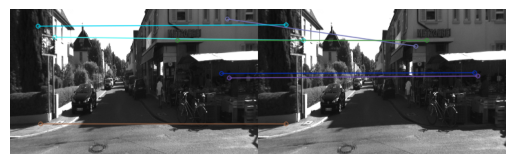

In [16]:
kp_net.eval()

with torch.no_grad():
    kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
    kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0.005)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0.005)

infer_keypoints1 = kp_1.detach().cpu().numpy()
infer_keypoints2 = kp_2.detach().cpu().numpy()


def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))

# Apply Lowe's ratio test
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
img1 = (img1*255).astype('uint8')
img2 = (img2*255).astype('uint8')
# Draw the top N matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=2)

# Display the result
# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()
